In [ ]:
%pylab inline
import cv2

In [285]:
cv2.__version__

'3.4.2'

In [181]:
kernel3 = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
kernel5 = array([[0., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 0.]],dtype=np.uint8)
def segment_cells(gray,kernel=kernel3,offset=-20):
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY,101,offset)

    # noise removal
    #clean = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    #clean = cv2.morphologyEx(clean,cv2.MORPH_CLOSE,kernel, iterations = 2)
    clean=cv2.erode(thresh,kernel,iterations = 8)
    Stats=cv2.connectedComponentsWithStats(thresh)
    return Stats

def _imshow(image):
    figure(figsize=(15,15))
    imshow(image,cmap='gray')

# compute boundaries
def mark_boundaries(segmentation,tile):
    kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
    clean=np.array((segmentation>0)*255,dtype=np.uint8)
    bigger = cv2.dilate(clean,kernel,iterations=1)
    smaller = cv2.erode(clean,kernel,iterations=1)
    smaller = np.uint8(smaller)
    borders = cv2.subtract(bigger,smaller)
    borders3=np.multiply.outer(borders,np.array([0,1,0],dtype=np.uint8))
    marked_tile=tile.copy()
    marked_tile[borders3>0]=np.max(marked_tile.flatten())
    figure(figsize=(15,15))
    imshow(marked_tile)
def circle_patch(radius):
    size=2*radius+1
    x=arange(-radius,radius+1)
    xx=np.array([x for i in x])
    yy=xx.T
    d=sqrt(xx**2+yy**2)
    return array((d<radius+0.1)*1,dtype=np.uint8)

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['gray', 'size', 'tile']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [284]:
%%time
tile=imread('../../../data/tiles/tiles_465.tif')
gray = -cv2.cvtColor(tile,cv2.COLOR_BGR2GRAY)
_imshow(gray)

AttributeError: module 'numpy' has no attribute 'imread'

In [283]:
type(gray[0,0])

numpy.uint8

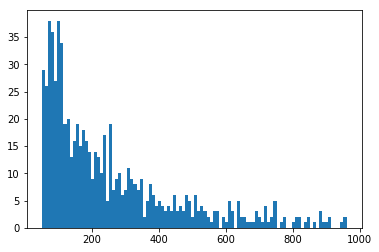

In [183]:

Stats = segment_cells(gray)

sizes=Stats[2][1:,-1]
hist(sizes[((sizes<1000) & (sizes>50))],bins=100);

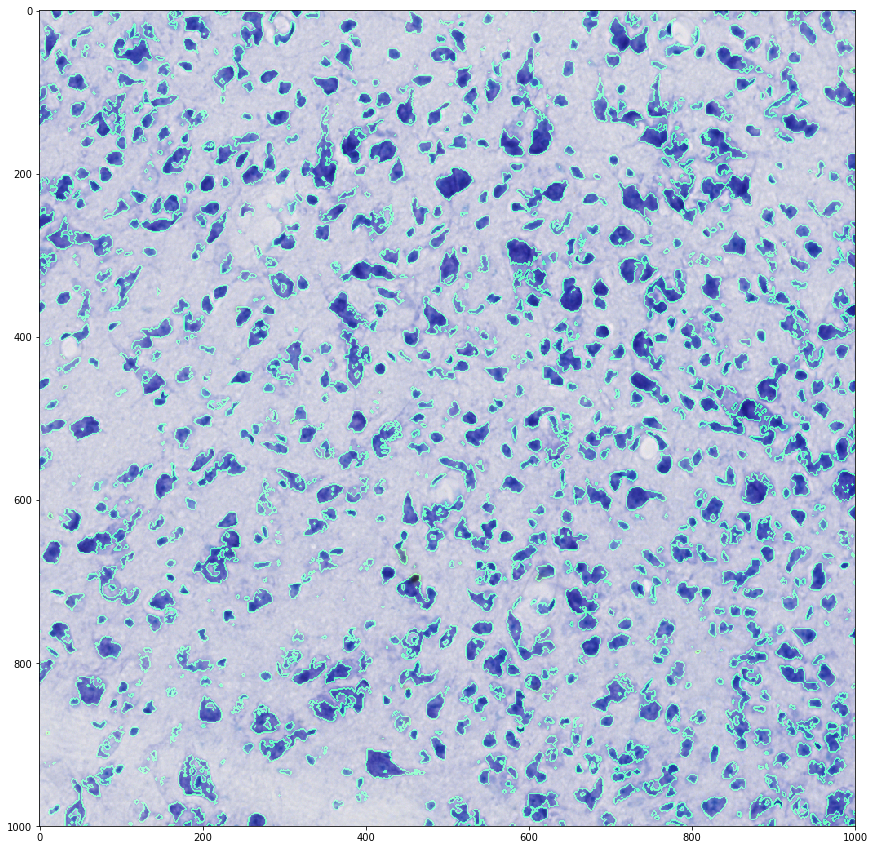

In [184]:
mark_boundaries(Stats[1],tile)

In [185]:
[x.shape for x in Stats[1:]]

[(1000, 1000), (1307, 5), (1307, 2)]

In [251]:
def extract_blobs(Stats,tile,gray,min_area=10,margin=2):
    """given a set of connected components extract convexified components from gray image and annotate on color image(tile)

    :param Stats: Output from cv2.connectedComponentsWithStats
    :param tile: original image
    :param gray: tile transfrmed to grey-scale
    :param min_area: minimal patch area (optional)
    :param margin: The margin around the patch in x and y (optinal) 
    :returns: 
    :rtype: 

    """
     # parse Stats
    no_blobs,seg,props,location = Stats

    left= props[:,0]
    top = props[:,1]
    width = props[:,2]
    height = props[:,3]
    area = props[:,4]

    marked_tile=copy(tile)
    size_step=20
    subs={}
    H,W=seg.shape
    for i in range(1,no_blobs):
        if area[i]<min_area:
            continue
        #extract patch
        t,b,l,r = top[i],top[i]+height[i],left[i],left[i]+width[i]
        if t==0 or b==H or l==0 or r==W: #ignore patches that touch the boundary (likely to be trimmed)
            continue
        t=max(0,t-margin)
        b=min(H,b+margin)
        l=max(0,l-margin)
        r=min(W,r+margin)

        # Extract connected component
        sub_mask = np.array((seg[t:b,l:r]==i)*1,dtype=np.uint8)
        # recover threshold that was used
        masked_image=copy(gray[t:b,l:r])
        masked_image[sub_mask==0]=255
        _thr=np.min(masked_image.flatten())

        # compute convex hull of sub_mask
        im2, contours, hierarchy = cv2.findContours(sub_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        convex_contour=cv2.convexHull(contours[0][:,0,:],returnPoints=True)
        slate=np.zeros([b-t,r-l,3],dtype=np.uint8)
        convex_mask = cv2.drawContours(slate, [convex_contour],0,(0,255,0),-1)[:,:,1]


        #compute Threshold used 
        masked_image=np.array(gray[t:b,l:r],dtype=np.int16)-_thr
        masked_image[convex_mask==0]=0
        masked_image[masked_image<0]=0

        # Quantize size
        size=area[i]
        size_factor=0.5
        size=int(10**(int(log10(size)/size_factor)*size_factor))
        
        #add extracted blob to a list according to it's quantized size
        if size in subs:
            subs[size].append(masked_image)
        else:
            subs[size] = [masked_image]    
        cv2.drawContours(marked_tile[t:b,l:r], [convex_contour],0,(0,255,0),1)
    return subs,marked_tile


In [252]:
subs,marked_tile = extract_blobs(Stats,tile,gray)
len(subs)

5

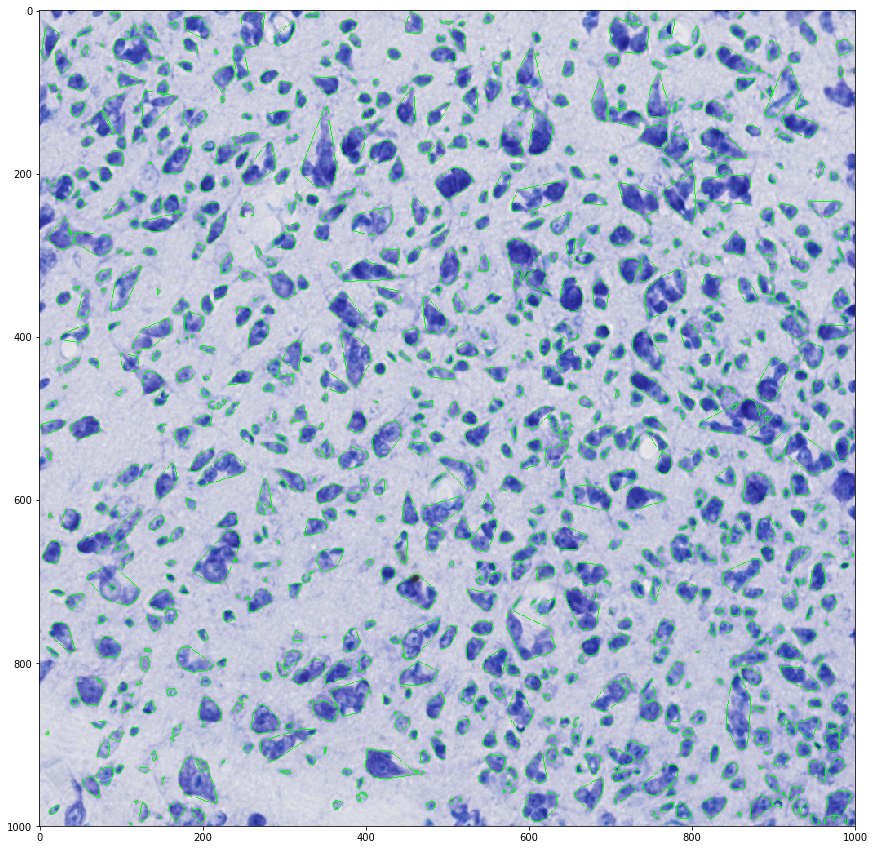

In [253]:
figure(figsize=(15,15))
imshow(marked_tile);

In [254]:
[(key,len(subs[key])) for key in sorted(subs.keys())]

[(10, 141), (31, 207), (100, 327), (316, 188), (1000, 16)]

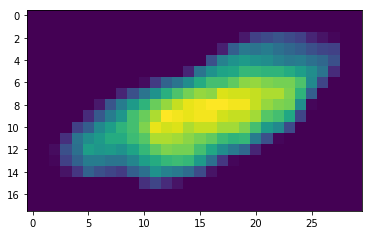

In [282]:
imshow(subs[100][90])


In [245]:
log10(100)

2.0

In [286]:
np.log10?